In [12]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
import numpy as np
import time
import random

## 3.1.2. Vectorization for Speed

- Timer: benchmark the running time frequently 

In [4]:
class Timer:  #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [10]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [8]:
print("speed of for-loop")
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

speed of for-loop


'0.12531 sec'

In [9]:
print("speed of vectorizated calculation")
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

speed of vectorizated calculation


'0.00020 sec'

## 3.2. Linear Regression Implementation from Scratch

#### (1) Generate input data and its label
- We generate a dataset containing 1000 examples, each consisting of 2 features sampled from a standard normal distribution
- Input dataset will be a matrix  𝐗∈ℝ1000×2
- 𝐰=[2,−3.4]⊤  and 𝑏=4.2
- 𝐲=𝐗𝐰+𝑏+𝜖
- 𝜖  obeys a normal distribution with mean of 0 (we will set its standard deviation to 0.01)

In [17]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w))) # generate 1000 random input data from normal distribution
    y = torch.matmul(X, w) + b # generate target data corresponding to the generated inputs
    y += torch.normal(0, 0.01, y.shape) ## 𝜖 with zero mean and standard deviation to 0.01
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

example of a input and its lable
input: tensor([-0.2218,  1.2575]) 
label: tensor([-0.5267])


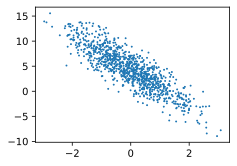

In [21]:
print("example of a input and its lable")
print('input:', features[0],'\nlabel:', labels[0])

d2l.set_figsize()
d2l.plt.scatter(d2l.numpy(features[:, 1]), d2l.numpy(labels), 1);

#### (2) Minimatch
- Defining a utility function to shuffle the dataset and access it in minibatches.
- example function) data_iter
  - The function takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of the size batch_size

##### However, it's inefficient!
- it requires that we load all the data in memory and that we perform lots of random memory access.
- Pytorch provides built-in iterators implemented in a deep learning framework
  - torch.utils.data.DataLoader

In [59]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [30]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.3050, -0.4536],
        [ 0.3395,  2.3712],
        [-1.3890, -0.0756],
        [-1.6174,  0.9255],
        [ 0.2670,  1.1335],
        [-1.8502, -1.0094],
        [-0.9786, -0.0492],
        [ 1.1812, -1.0517],
        [ 0.9022, -0.2662],
        [-1.0057, -0.8731]]) 
 tensor([[ 8.3619],
        [-3.1911],
        [ 1.6801],
        [-2.1837],
        [ 0.8740],
        [ 3.9248],
        [ 2.4293],
        [10.1358],
        [ 6.9153],
        [ 5.1602]])


#### (3) Defining a model

In [31]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

#### (4) Defining the loss function

In [39]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#### (5) Defining the Optimization Algorithm
- Minibatch stochastic gradient descent with fixed learning rate lr

In [42]:
def sgd(params, lr, batch_size):
    # update parameter weights for given pairs of a parameter and its gradients
    for param in params:
        param.data.sub_(lr*param.grad/batch_size)
        param.grad.data.zero_()

#### (6) Training

- Training loop
  - Initialize parameters (𝐰,𝑏) 
  - Repeat until done (for each epoch)
    - Compute gradient
    - Update parameters


- Hyperparameters for this example
  - The number of epochs num_epochs and the learning rate lr are both 

In [60]:
lr = 0.03
batch_size = 10
num_epochs = 3
net = linreg
loss = squared_loss

# Initializing Model Parameters to train
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)    # Minibatch loss in `X` and `y`
        l.sum().backward()           # Compute gradient on `l` with respect to [`w`, `b`]
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.034255
epoch 2, loss 0.000131
epoch 3, loss 0.000050


In [48]:
print('calculate parameter errorr (L1 dist)')
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

calculate parameter errorr (L1 dist)
error in estimating w: tensor([0.0004, 0.0001], grad_fn=<SubBackward0>)
error in estimating b: tensor([-1.1444e-05], grad_fn=<RsubBackward1>)


##### Should ML must find exactly fitted parameters?
Even though there are some error in the predicted parameters, we are typically less concerned with recovering true underlying parameters
- since ML is more concerned with parameters that lead to highly accurate 'prediction' especially for unseen data (generalization performance)
- Whereas, for statistics, the purpose of regression is most often to characterize the relationship between the inputs and outputs

## 3.3. Implementation of Linear Regression by using high-level APIs

#### (1) Generate input data and its label

In [49]:
from d2l import torch as d2l
import numpy as np
import torch
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

#### (2) Minibatch
##### DataLoader API
- Rather than rolling our own iterator, we can call upon the existing API in a framework to read data

In [61]:
def load_array(data_arrays, batch_size, do_shuffle=True):  #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=do_shuffle)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [62]:
next(iter(data_iter))

[tensor([[ 0.8594,  0.8831],
         [-0.2662,  0.3199],
         [ 0.6361, -1.7203],
         [ 0.1367, -0.0954],
         [ 0.2499, -1.8392],
         [ 0.1706, -0.4503],
         [ 0.2405,  1.4781],
         [ 1.4547, -0.2408],
         [-1.4465, -0.1999],
         [-0.1247, -1.3135]]),
 tensor([[ 2.9020],
         [ 2.5559],
         [11.3411],
         [ 4.7886],
         [10.9474],
         [ 6.0684],
         [-0.3412],
         [ 7.9140],
         [ 1.9746],
         [ 8.4367]])]

#### (3) Defining the Model
- Sequential class defines a container for several layers that will be chained together
  - The layer is said to be fully-connected, because each of its inputs is connected to each of its outputs by means of a matrix-vector multiplication.
- Sequential instance passes it through the first layer, in turn passing the output as the second layer’s input and so forth

In [63]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

#### (4) Defining the Loss Function
- MSELoss class computes the mean squared error, also known as squared  𝐿2  norm

In [64]:
loss = nn.MSELoss()

#### (5) Defining the Optimization Algorithm
- When we instantiate an SGD instance, we will specify the parameters to optimize over (obtainable from our net via net.parameters()),
- lr, which is set to 0.03 here.

In [65]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

#### (6) Training
- Generate predictions by calling net(X) and calculate the loss l (the forward propagation).
- Calculate gradients by running the backpropagation.
- Update the model parameters by invoking our optimizer.

In [66]:
# a model instances contains its directly accessible parameters
net[0].weight.data.normal_(0, 0.01) 
net[0].bias.data.fill_(0)

num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000248
epoch 2, loss 0.000099
epoch 3, loss 0.000101


In [67]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([ 0.0007, -0.0004])
error in estimating b: tensor([0.0014])
